In [1]:
import os
import zipfile
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score


In [2]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
import shutil
import os

def copy_folders(src_path, dest_path):
    # Copy src_path to dest_path
    shutil.copytree(src_path, dest_path)



train_dataset = ImageFolder('train', transform=transform)
test_dataset = ImageFolder('test', transform=transform)
valid_dataset = ImageFolder('valid', transform=transform)


In [4]:



# Create DataLoader for each dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


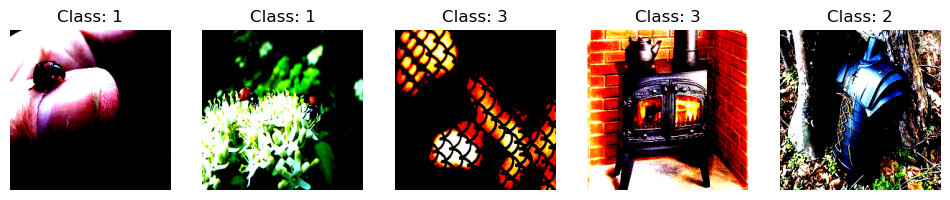

In [5]:
import matplotlib.pyplot as plt
import numpy as np


def show_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 3))
    for ax, image, label in zip(axes, images, labels):
        ax.imshow(np.transpose(image.numpy(), (1, 2, 0)))
        ax.set_title(f'Class: {label}')
        ax.axis('off')
    plt.show()


for images, labels in train_loader:
    break

show_images(images[:5], labels[:5])


In [6]:

vgg_model = models.vgg16(pretrained=True)
googlenet_model = models.googlenet(pretrained=True)

for param in vgg_model.parameters():
    param.requires_grad = False

for param in googlenet_model.parameters():
    param.requires_grad = False


/Users/krishna/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/krishna/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/krishna/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [04:05<00:00, 2.25MB/s] 
/Users/krishna/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are dep

In [7]:

def extract_features(loader, model):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in loader:
            outputs = model(images)
            features.extend(outputs.numpy())
            labels.extend(targets.numpy())
    return np.array(features), np.array(labels)


train_features_vgg, train_labels_vgg = extract_features(train_loader, vgg_model)
test_features_vgg, test_labels_vgg = extract_features(test_loader, vgg_model)
valid_features_vgg, valid_labels_vgg = extract_features(valid_loader, vgg_model)

train_features_googlenet, train_labels_googlenet = extract_features(train_loader, googlenet_model)
test_features_googlenet, test_labels_googlenet = extract_features(test_loader, googlenet_model)
valid_features_googlenet, valid_labels_googlenet = extract_features(valid_loader, googlenet_model)


In [8]:

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize MLP models
input_size_vgg = train_features_vgg.shape[1]
input_size_googlenet = train_features_googlenet.shape[1]
hidden_size1 = 256
hidden_size2 = 128
num_classes = len(np.unique(train_labels_vgg))

mlp_vgg = MLP(input_size_vgg, hidden_size1, hidden_size2, num_classes)
mlp_googlenet = MLP(input_size_googlenet, hidden_size1, hidden_size2, num_classes)


In [9]:

def train_mlp(model, features, labels, lr=0.001, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(torch.from_numpy(features).float())
        loss = criterion(outputs, torch.from_numpy(labels))
        loss.backward()
        optimizer.step()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


train_mlp(mlp_vgg, train_features_vgg, train_labels_vgg)
train_mlp(mlp_googlenet, train_features_googlenet, train_labels_googlenet)


Epoch [1/10], Loss: 1.6833
Epoch [2/10], Loss: 0.7517
Epoch [3/10], Loss: 0.3490
Epoch [4/10], Loss: 0.1790
Epoch [5/10], Loss: 0.1154
Epoch [6/10], Loss: 0.0850
Epoch [7/10], Loss: 0.0698
Epoch [8/10], Loss: 0.0629
Epoch [9/10], Loss: 0.0579
Epoch [10/10], Loss: 0.0532
Epoch [1/10], Loss: 1.6165
Epoch [2/10], Loss: 1.2459
Epoch [3/10], Loss: 0.9109
Epoch [4/10], Loss: 0.5948
Epoch [5/10], Loss: 0.3475
Epoch [6/10], Loss: 0.1913
Epoch [7/10], Loss: 0.1089
Epoch [8/10], Loss: 0.0705
Epoch [9/10], Loss: 0.0530
Epoch [10/10], Loss: 0.0444


In [10]:

def evaluate_model(model, features, labels):
    model.eval()
    outputs = model(torch.from_numpy(features).float())
    _, predicted = torch.max(outputs, 1)
    acc = accuracy_score(labels, predicted.numpy())
    print(f'Accuracy: {acc:.4f}')


print("VGGNet Model:")
evaluate_model(mlp_vgg, test_features_vgg, test_labels_vgg)

print("GoogLeNet Model:")
evaluate_model(mlp_googlenet, test_features_googlenet, test_labels_googlenet)

print("VGGNet Model:")
evaluate_model(mlp_vgg, valid_features_vgg, valid_labels_vgg)

print("GoogLeNet Model:")
evaluate_model(mlp_googlenet, valid_features_googlenet, valid_labels_googlenet)


VGGNet Model:
Accuracy: 0.9800
GoogLeNet Model:
Accuracy: 0.9920
VGGNet Model:
Accuracy: 0.9860
GoogLeNet Model:
Accuracy: 0.9900


In [13]:
print("VGGNet Model:")
evaluate_model(mlp_vgg, train_features_vgg, train_labels_vgg)
evaluate_model(mlp_vgg, test_features_vgg, test_labels_vgg)
evaluate_model(mlp_vgg, valid_features_vgg, valid_labels_vgg)

print("GoogLeNet Model:")
evaluate_model(mlp_googlenet, train_features_googlenet, train_labels_googlenet)
evaluate_model(mlp_googlenet, test_features_googlenet, test_labels_googlenet)
evaluate_model(mlp_googlenet, valid_features_googlenet, valid_labels_googlenet)

VGGNet Model:
Accuracy: 0.9820
Accuracy: 0.9800
Accuracy: 0.9860
GoogLeNet Model:
Accuracy: 0.9855
Accuracy: 0.9920
Accuracy: 0.9900
